##Цель проекта

В нашем проекте мы:
1. Проведем разведочный анализ фильмов и сериалов сервиса Netflix с помощью  pandas, seaborn, matplotlib и plotly
2. Построим рекомендательную систему (content based)

Данные мы возьмем здесь - https://www.kaggle.com/datasets/shivamb/netflix-shows



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Подготовка данных

In [ ]:
df.isna().any()

show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool

Пропуски есть. Больше всего их в колонке director. Однако это не помешает нашему дальнейшему анализу.

In [ ]:
#удалим ненужную колонку
df.drop("show_id", axis = 1, inplace = True)

###Поделим наш датасет на фильмы и сериалы, посмотрим чего больше фильмов или сериалов.

In [ ]:
movies = df[df['type'] == 'Movie']
tvshows = df[df['type'] == 'TV Show']

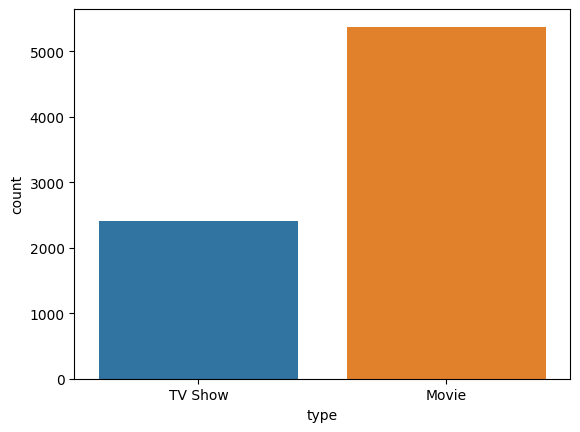

In [ ]:
ax = sns.countplot(x = 'type', data = df)

##Анализ данных

### Какой месяц наиболее привлекательный для релиза контента?
Обратимся к колонке date_added

In [ ]:
#у datе_added были пропуски. удалим их.
df_date=df[['date_added']].dropna()

In [ ]:
#разобьем колонку на месяц и год
df_date['year'] = df_date['date_added'].apply(lambda x: x.split(', ')[-1])
df_date['month'] = df_date['date_added'].apply(lambda x: x.strip().split(' ')[0])

#преобразуем df_date в сводную таблицуб заполним "перерывы" и определим порядок отображение месяцев
months_order = ['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']
pt = df_date.groupby('year')['month'].value_counts().unstack().fillna(0)[months_order].T

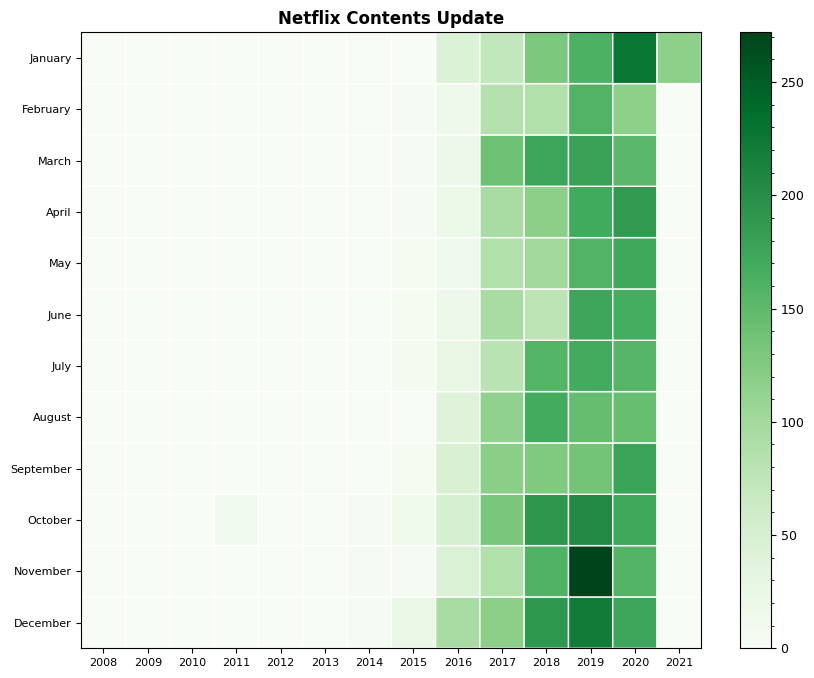

In [ ]:
#создадим тепловую карту
plt.figure(figsize=(10, 8), dpi=100)
plt.pcolor(pt, cmap='Greens', edgecolors='white', linewidths=1)
plt.xticks(np.arange(0.5, len(pt.columns), 1), pt.columns, fontsize=8)
plt.yticks(np.arange(0.5, len(pt.index), 1), pt.index, fontsize=8)

plt.title('Netflix Contents Update', fontsize=12, fontweight='bold')
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=9)
cbar.ax.minorticks_on()
plt.show()

Здесь мы можем увидеть наиболее свободные периоды для релиза собственного контента. Стоит отметить что наиболее успешные для фильмов месяцы приходятся на праздники и каникулы - Новый Год, Рождество и летние каникулы.

### Количество фильмов по рейтингам

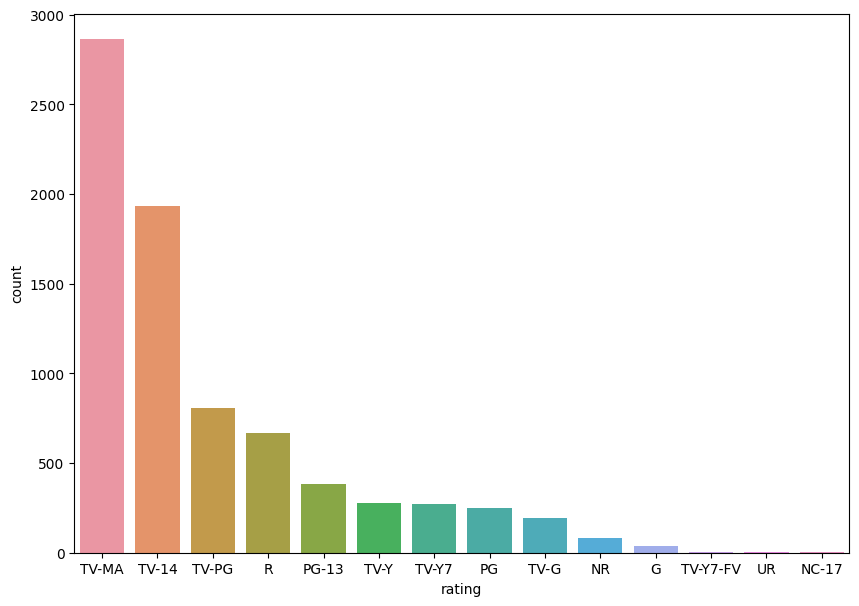

In [ ]:
plt.figure(figsize = (10, 7))
ax = sns.countplot(x=df['rating'], data = movies, order = df['rating'].value_counts().index[:15])

Здесь мы видим три самых популярных рейтинга фильмов. Первый - исключительно для взрослых. Второй - для детей и подростков.

###Фильмы по дате релиза

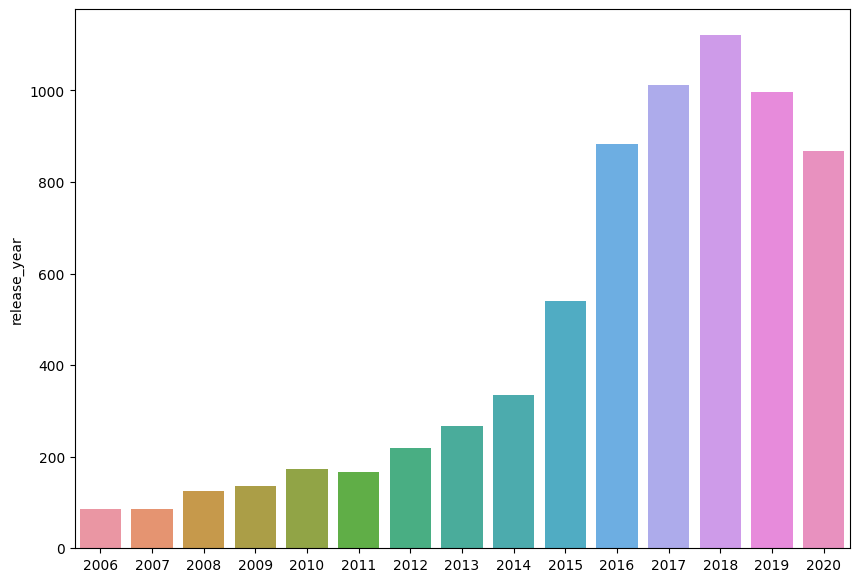

In [ ]:
#выведем данные за 15 лет по каждому году
year_films = df['release_year'].value_counts()[:15]

plt.figure(figsize = (10, 7))
ax = sns.barplot(x = year_films.index, y = year_films)

Здесь, мы можем увидеть влияние ковида на производство фильмов

### Какие страны чаще всего выпускают фильмы?
Заполним пропуски на 'country unknown'

In [ ]:
movies['country'] = movies['country'].fillna('country_unknown')

Определим небольшую функцию, которая будет делить списки стран в колонке страны на отдельные. Так будет посчитан вклад каждой страны в создание фильмов

In [ ]:
c_dict = {}

def counter (l, d):
  listed = list(l)
  for i in listed:
    i = i.replace(' ', '')
    i = i.split(',')
    for j in i:
      if j in d.keys():
        d[j] += 1
      else:
        d[j] =1
  return d

counter(movies['country'], c_dict)

{'Mexico': 101,
 'Singapore': 18,
 'UnitedStates': 2431,
 'Egypt': 97,
 'India': 915,
 'Thailand': 43,
 'Nigeria': 68,
 'Norway': 20,
 'Iceland': 7,
 'UnitedKingdom': 467,
 'SouthKorea': 55,
 'Italy': 67,
 'Canada': 286,
 'Indonesia': 77,
 'Romania': 12,
 'Spain': 158,
 'Turkey': 80,
 'SouthAfrica': 44,
 'France': 265,
 'Portugal': 4,
 'country_unknown': 230,
 'HongKong': 97,
 'China': 102,
 'Germany': 157,
 'Argentina': 64,
 'Serbia': 7,
 'Denmark': 31,
 'Poland': 28,
 'Japan': 103,
 'Kenya': 5,
 'NewZealand': 20,
 'Pakistan': 20,
 'Australia': 84,
 'Taiwan': 15,
 'Netherlands': 37,
 'Philippines': 77,
 'UnitedArabEmirates': 33,
 'Brazil': 59,
 'Iran': 4,
 'Belgium': 74,
 'Israel': 18,
 'Uruguay': 13,
 'Bulgaria': 9,
 'Chile': 21,
 'Colombia': 17,
 'Algeria': 2,
 'SovietUnion': 3,
 'Sweden': 29,
 'Malaysia': 18,
 'Ireland': 28,
 'Luxembourg': 10,
 'Austria': 10,
 'Peru': 10,
 'Senegal': 2,
 'Switzerland': 16,
 'Ghana': 4,
 'SaudiArabia': 6,
 'Armenia': 1,
 'Jordan': 7,
 'Mongolia': 1,

In [ ]:
#удалим нераспознанный ключ
del c_dict['']

In [ ]:
##отсортируем с помощью функции и выведем первые 25
def sorter (x):
  return sorted(x.items(), key=lambda item: x[item[0]], reverse = True)[:25]

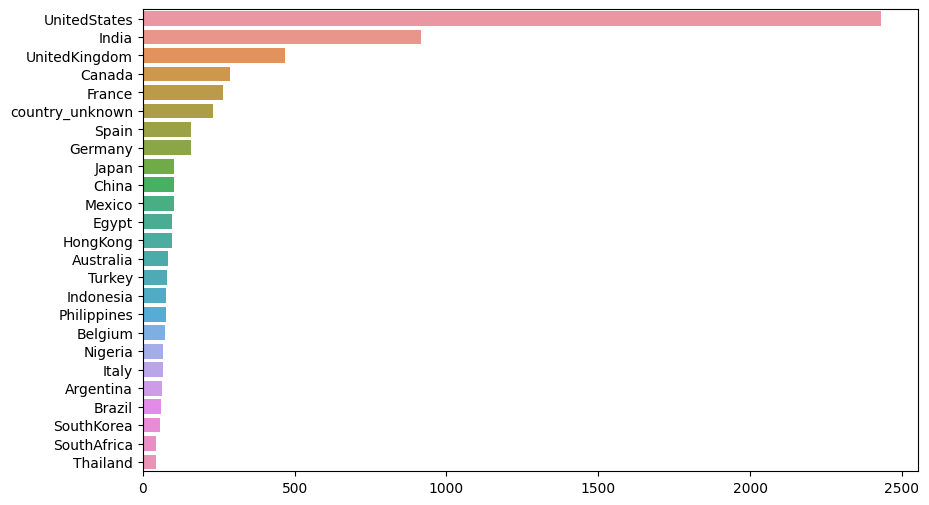

In [ ]:
names = [name for name, val in sorter(c_dict)]
values = [val for name, val in sorter(c_dict)]

plt.figure(figsize = (10, 6))
sns.barplot (y = names, x = values);

США и Индия в верху топа. Там находятся Голливуд и Болливуд - одни из самых больших мест по производству фильмов и сериалов.

### Фильмы по продолжительности

In [ ]:
#удалим минуты
movies['duration'] = movies['duration'].str.replace(' min', '').astype(int)

<Axes: xlabel='duration', ylabel='Density'>

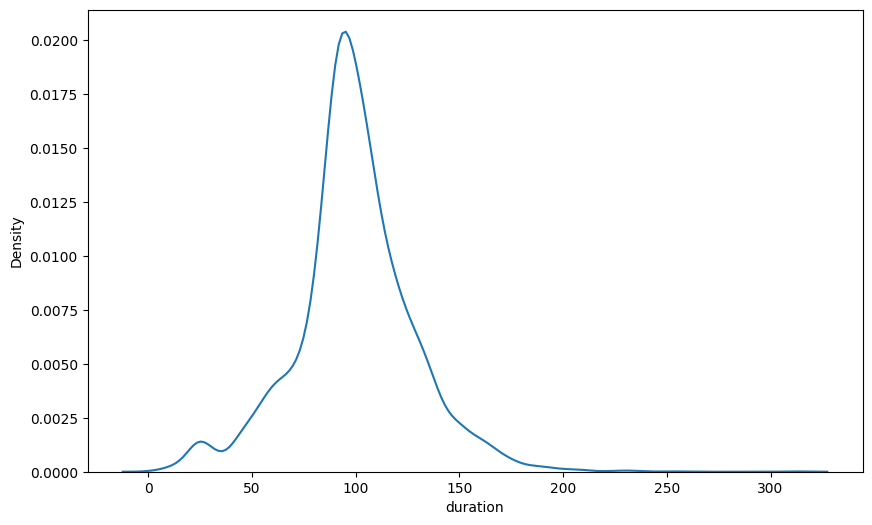

In [ ]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = movies['duration'], data = movies)

Наиболее популярное время - примерно, 1.5 часа. Также, распространены короткометражки. Мы можем увидеть это на графике.

### Наиболее популярные жанры фильмов

In [ ]:
g_dict = {}
#также разделим списки жанров и посчитаем каждый
counter(movies['listed_in'], g_dict)

{'Dramas': 2106,
 'InternationalMovies': 2437,
 'HorrorMovies': 312,
 'Action&Adventure': 721,
 'IndependentMovies': 673,
 'Sci-Fi&Fantasy': 218,
 'Thrillers': 491,
 'Documentaries': 786,
 'SportsMovies': 196,
 'Comedies': 1471,
 'RomanticMovies': 531,
 'Movies': 56,
 'Music&Musicals': 321,
 'LGBTQMovies': 90,
 'Faith&Spirituality': 57,
 'Children&FamilyMovies': 532,
 'ClassicMovies': 103,
 'CultMovies': 59,
 'Stand-UpComedy': 329,
 'AnimeFeatures': 57}

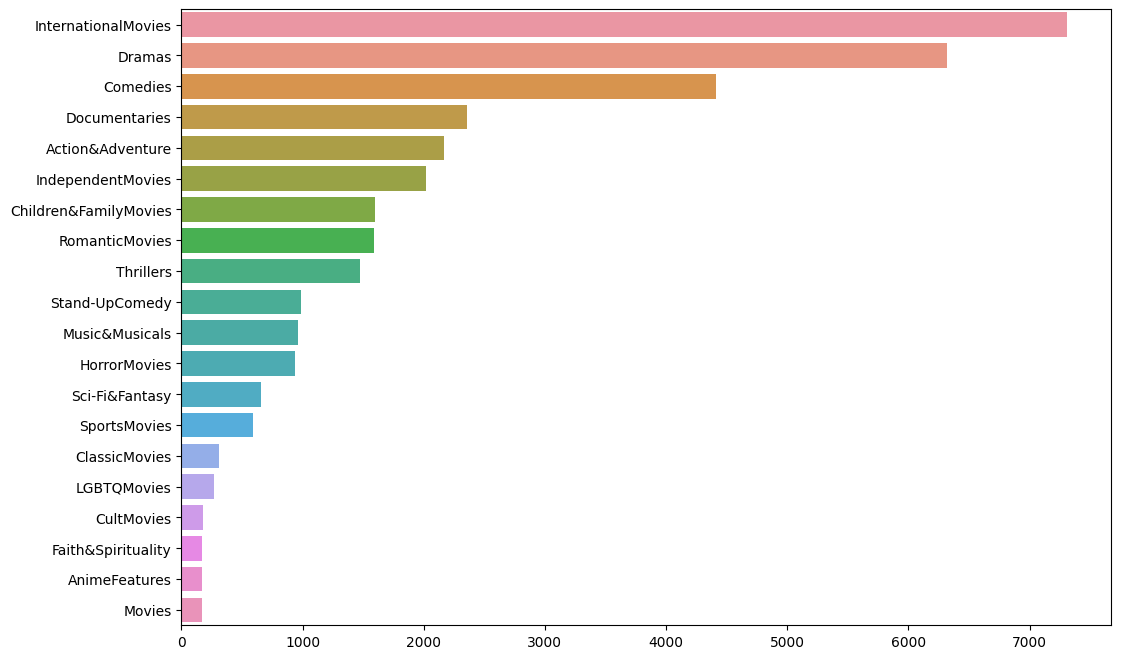

In [ ]:
#отсортируем с помощью функции
g_names = [name for name, val in sorter(counter(movies['listed_in'], g_dict))]
g_values = [val for name, val in sorter(counter(movies['listed_in'], g_dict))]
#создадим график
plt.figure(figsize=(12,8))
ax = sns.barplot(x = g_values, y = g_names)
plt.yticks(fontsize = 10);

На первом месте - international movies. Это обозначение фильмов снятых не в США. На втором и третьем драма и комедия. Интересно, что следом за ними идет документальный жанр. Это может объяснятся популярностью фильмов-расследований, таких как Аферист из Тиндера и Hunting an Internet Killer.

# Анализ сериалов


##Какие страны чаще всего создавали сериалы?

In [ ]:
#заполним пропуски
tvshows['country'] = tvshows['country'].fillna('unknown_country')

In [ ]:
c_dict2 = {}
#снова примерим нашу функцию
counter(tvshows['country'], c_dict2)

{'Brazil': 29,
 'Turkey': 28,
 'Poland': 8,
 'UnitedStates': 866,
 'Mexico': 53,
 'unknown_country': 277,
 'Japan': 184,
 'SouthKorea': 157,
 'UnitedKingdom': 256,
 'India': 75,
 'Canada': 126,
 'Italy': 23,
 'Spain': 57,
 'Australia': 60,
 'Taiwan': 70,
 'China': 45,
 'Germany': 42,
 'France': 84,
 'Singapore': 21,
 'Russia': 17,
 'Mauritius': 1,
 'SouthAfrica': 10,
 'Lebanon': 7,
 'Colombia': 28,
 'Argentina': 18,
 'Philippines': 1,
 'Finland': 4,
 'Netherlands': 8,
 'Chile': 5,
 'Thailand': 22,
 'Nigeria': 8,
 'SaudiArabia': 4,
 'Syria': 1,
 'Egypt': 13,
 'Kuwait': 3,
 'Belgium': 11,
 'Norway': 9,
 'Sweden': 10,
 'Denmark': 13,
 'Israel': 8,
 'Ireland': 12,
 'Iceland': 2,
 'Indonesia': 3,
 'Malaysia': 8,
 'NewZealand': 8,
 'CzechRepublic': 6,
 'Cuba': 1,
 'Austria': 1,
 'Greece': 2,
 'HongKong': 5,
 'Pakistan': 4,
 'Luxembourg': 1,
 'Jordan': 1,
 'Uruguay': 1,
 'Azerbaijan': 1,
 'WestGermany': 2,
 'PuertoRico': 1,
 'Malta': 1,
 'Senegal': 1,
 'Ukraine': 2,
 'Switzerland': 1,
 'Belar

In [ ]:
#отсортируем
names = [name for name, val in sorter(counter(tvshows['country'], c_dict2))]
values = [val for name, val in sorter(counter(tvshows['country'], c_dict2))]

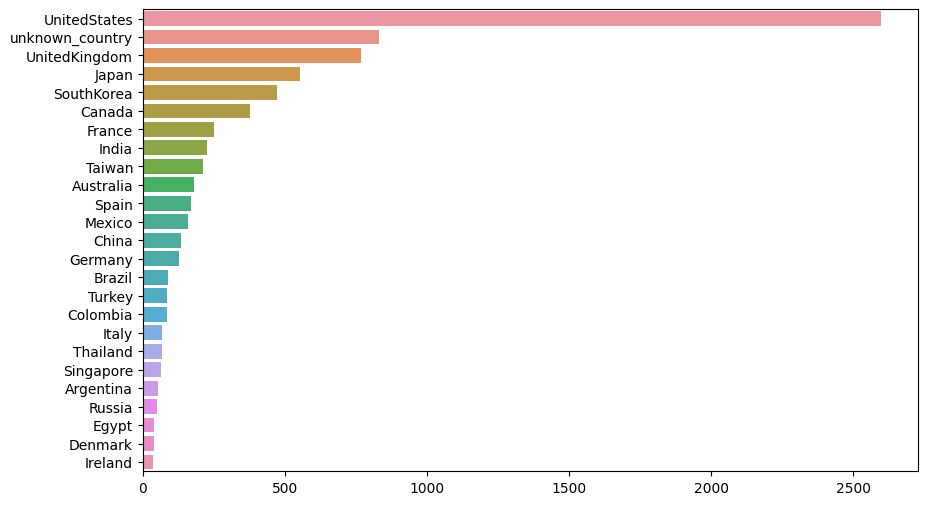

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(y = names, x = values)
plt.yticks(fontsize = 10);

## Какая самая популярная длительность сериалов?

In [ ]:
#отформатируем столбец оставим только числа и переведем их в int
tvshows['duration_int']=tvshows['duration'].str.replace('Season', '').str.replace('s', '').astype(int)

Text(0.5, 0, 'seasons')

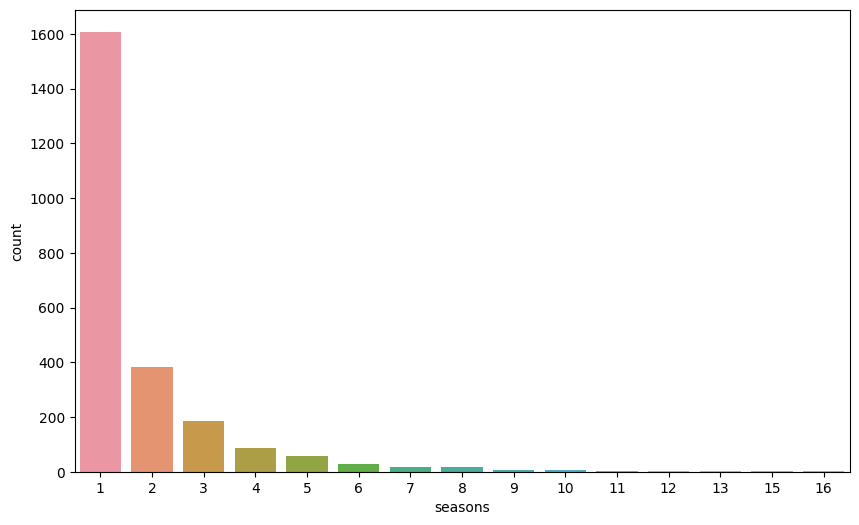

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x = tvshows['duration_int'], data = tvshows)
plt.xlabel('seasons')

Длительность в один сезон является наиболее популярной (у этого могут быть и другие причины помимо популярности, например, недостаточк финансирования или низкие просмотры)

##У каких сериалов больше всего сезонов?

In [ ]:
tv_dur = tvshows[['title','duration_int']]
#выберем первые 25
top=tv_dur.sort_values(by = 'duration_int', ascending = False)[:25]

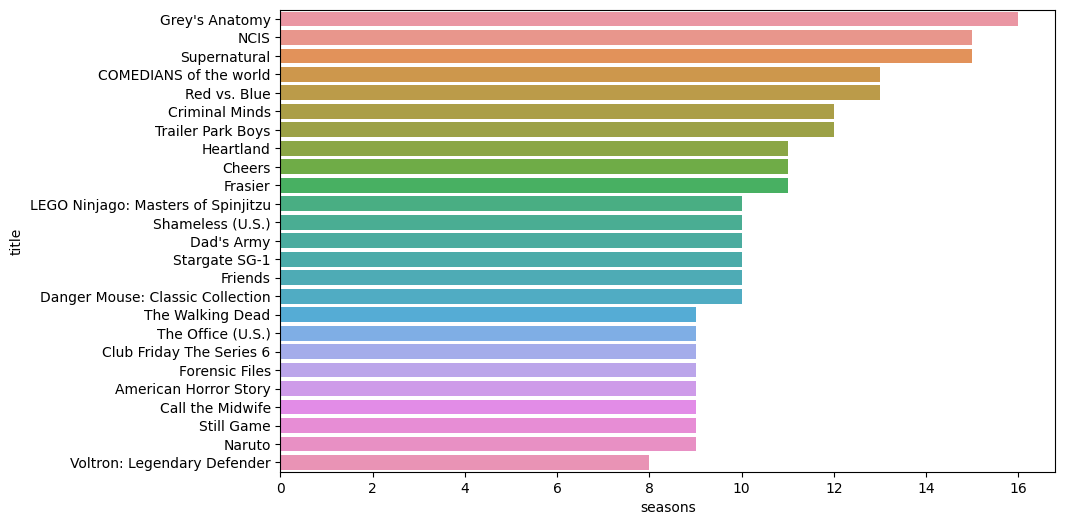

In [ ]:
plt.figure(figsize = (10, 6))
sns.barplot(y = top['title'], x = top['duration_int'])
plt.xlabel('seasons');

# Перейдем к построению рекомендательных систем
В построении рекомендательной системы мы будем опираться на Content Based метод.

Content Based - это метод рекомендации, который использует информацию о свойствах или содержании элементов для предсказания рекомендаций на основе схожести с предпочтениями пользователя.



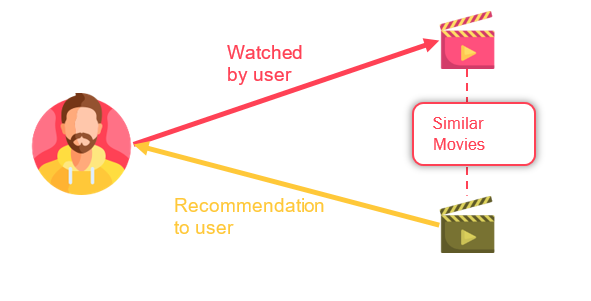

Рекоменодовать фильмы пользователям мы будем основываясь на описании фильма. В этом нам поможет TF-IDF.

TF-IDF (Term Frequency-Inverse Document Frequency) - это метод оценки важности слова в документе, учитывающий его частоту встречаемости в документе (!)и обратную частоту встречаемости в коллекции документов.







In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf = TfidfVectorizer(stop_words = 'english')
#обучаем и переводим в вектор (каждое описание фильма - вектор)
Tfidf_matrix = Tfidf.fit_transform(movies['description'])



Схожесть фильмов мы будем определять с помощью косинусной похожести (вычисление угла между векторами)



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
#Создадим матрицу с вещественными значениями
cosine_sim = cosine_similarity(Tfidf_matrix, Tfidf_matrix)
#Выделим индексы из основного датасета с фильмами
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

Создадим дата фрейм с нашими значениями похожести

In [ ]:
cosine_df = pd.DataFrame(cosine_sim)

cosine_df.columns = indices.index

cosine_df['title'] = indices.index
cosine_df = cosine_df.set_index('title')

cosine_df.head()

title,7:19,23:59,9,21,122,187,706,1920,1922,"2,215",...,Zoé: Panoramas,Zodiac,Zokkomon,Zombieland,Zoo,Zoom,Zozo,Zubaan,Zulu Man in Japan,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS
title,,,,,,,,,,,,,,,,,,,,,
7:19,1.0,0.0,0.000000,0.000000,0.0,0.027618,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.016381,0.0,0.000000,0.093052,0.0
23:59,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.042022,0.000000,0.0,0.000000,0.000000,0.0
9,0.0,0.0,1.000000,0.029333,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.023371,0.000000,0.000000,0.0,0.075939,0.000000,0.0
21,0.0,0.0,0.029333,1.000000,0.0,0.037268,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
122,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.041665,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


Напишем функцию, которая будет выдавать наиболее похожие фильмы к фильму клиента

In [ ]:
def recomendations (title, cosine_sim = cosine_df):
  idx = indices[title]
  scores = list(enumerate(cosine_df.loc[title])) #берем значения похожести

  scores = sorted(scores, key = lambda x: x[1], reverse = True)[:11] #сортируем

  m_indices = [i[0] for i in scores] #получаем индексы фильмов
  return movies['title'].iloc[m_indices] #возвращаем названия

##Проверяем получившуюся функцию

In [ ]:
recomendations('Zoom')

7781                        Zoom
5753                Spider-Man 3
4034                      Menahi
962             Black Site Delta
878            Beyond the Clouds
7061          Thorne: Sleepyhead
7180           Train of the Dead
7115            To Be of Service
886               Bhangra Paa Le
738     Barbie in Princess Power
4271                   Mugamoodi
Name: title, dtype: object

Посмотрим на описание фильма который нам понравился

In [ ]:
movies[movies['title'] == 'Zoom'].description.iloc[0]

'Dragged from civilian life, a former superhero must train a new crop of youthful saviors when the military preps for an attack by a familiar villain.'

А теперь - на описания, тех фильмов, которые нам порекомендовала функция

In [ ]:
movies[movies['title'] == 'Spider-Man 3'].description.iloc[0]

'The seemingly invincible Spider-Man goes up against an all-new crop of villains in the third installment of the blockbuster adventure series.'

In [ ]:
movies[movies['title'] == 'Menahi'].description.iloc[0]

'A stranger to civilian life, a young Saudi farmer travels to Dubai, where he experiences a series of hilarious misadventures.'

In [ ]:
movies[movies['title'] == 'Black Site Delta'].description.iloc[0]

'After discovering that their secret military prison is under attack by terrorists, a ragtag group of inmates does their best to neutralize the enemy.'

Как мы видим все отлично работает!